<center>
<img src="../../img/ods_stickers.jpg">


[Материал разработат на основе электронного ресурса](Ю.Кашницкого.https://mlcourse.ai/book/index.html)

In [ ]:
# <center> Модели классификации Pandas и Scikit-Learn.
# <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**При выполнении задания ответьте на вопросы**

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

**Функция для формирования csv-файла посылки на Kaggle:**

In [3]:
def write_to_submission_file(
    predicted_labels,
    out_file,
    train_num=891,
    target="Survived",
    index_label="PassengerId",
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(train_num + 1, train_num + 1 + predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки.**

In [4]:
train_df = pd.read_csv("../../data/titanic_train.csv")
test_df = pd.read_csv("../../data/titanic_test.csv")

In [5]:
y = train_df["Survived"]

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [8]:
test_df.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


**Заполним пропуски медианными значениями.**

In [10]:
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"] = test_df["Age"].fillna(train_df["Age"].median())  # используем медиану из train
train_df["Embarked"] = train_df["Embarked"].fillna("S")
test_df["Fare"] = test_df["Fare"].fillna(train_df["Fare"].median())

**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [11]:
train_df = pd.concat(
    [
        train_df,
        pd.get_dummies(train_df["Pclass"], prefix="PClass"),
        pd.get_dummies(train_df["Sex"], prefix="Sex"),
        pd.get_dummies(train_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(train_df["Parch"], prefix="Parch"),
        pd.get_dummies(train_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)
test_df = pd.concat(
    [
        test_df,
        pd.get_dummies(test_df["Pclass"], prefix="PClass"),
        pd.get_dummies(test_df["Sex"], prefix="Sex"),
        pd.get_dummies(test_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(test_df["Parch"], prefix="Parch"),
        pd.get_dummies(test_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)

In [12]:
train_df.drop(
    [
        "Survived",
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
    ],
    axis=1,
    inplace=True,
)
test_df.drop(
    [
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
    ],
    axis=1,
    inplace=True,
)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [13]:
train_df.shape, test_df.shape

((891, 24), (418, 25))

In [14]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [15]:
test_df.drop(["Parch_9"], axis=1, inplace=True)

In [16]:
train_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,False,False,True,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,True
1,38.0,71.2833,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
2,26.0,7.9250,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
3,35.0,53.1000,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
4,35.0,8.0500,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [17]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,True,False
1,47.0,7.0000,False,False,True,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
2,62.0,9.6875,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,True,False
3,27.0,8.6625,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True
4,22.0,12.2875,False,False,True,True,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True


## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [ ]:
# Обучите на имеющейся выборке дерево решений максимальной глубины 2
tree = DecisionTreeClassifier(max_depth=2, random_state=17)
tree.fit(train_df, y)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",17
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

**Сделайте с помощью полученной модели прогноз для тестовой выборки **

Прогнозы для тестовой выборки:
[0 0 0 0 0 0 0 0 0 0]


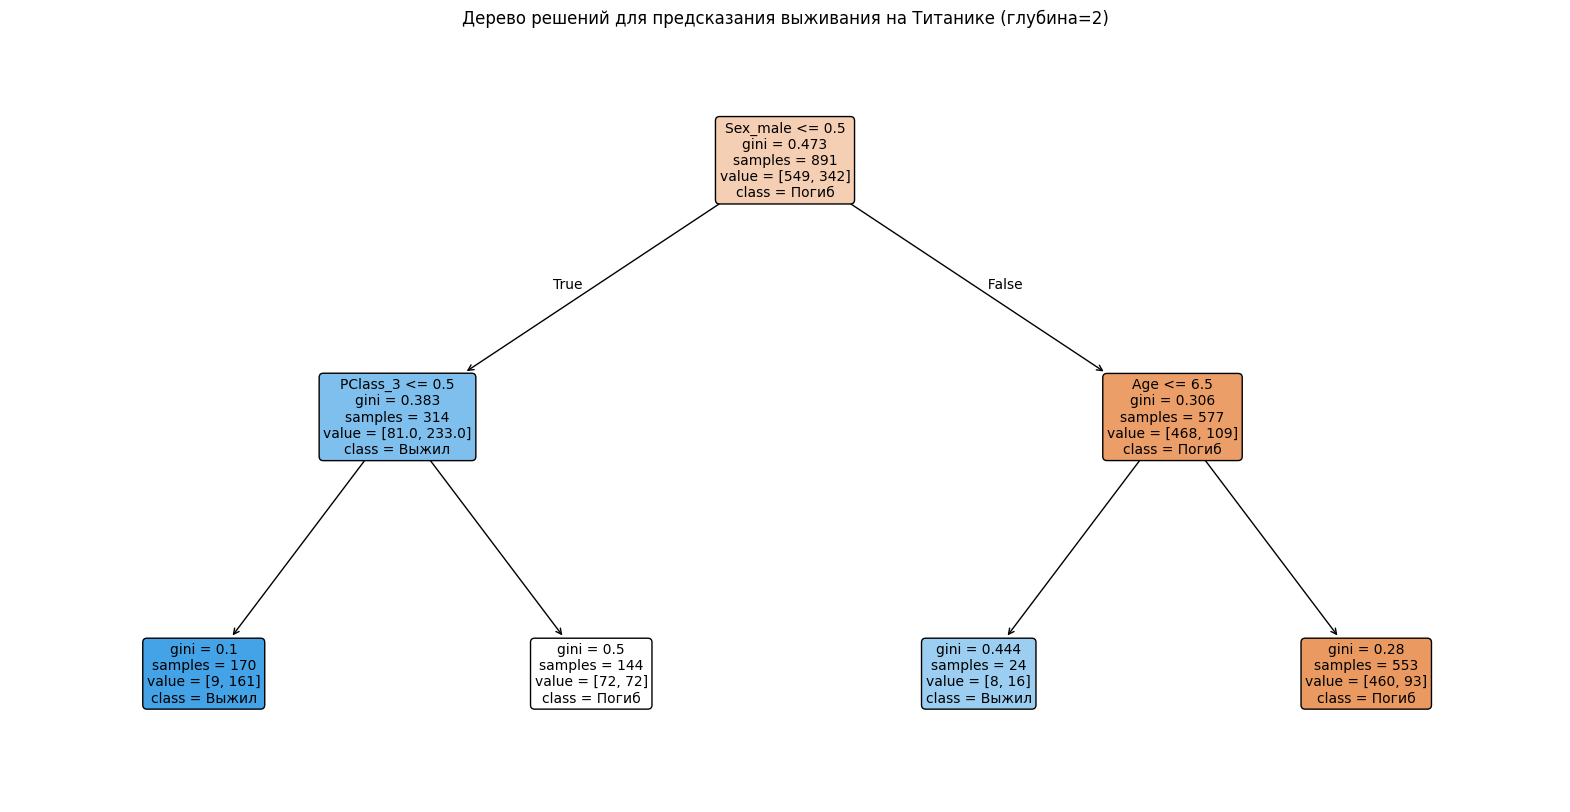

In [20]:
# Сделайте прогноз для тестовой выборки
test_predictions = tree.predict(test_df)
print("Прогнозы для тестовой выборки:")
print(test_predictions[:10])  # покажем первые 10 прогнозов

from sklearn.tree import plot_tree

# Обучаем дерево
tree = DecisionTreeClassifier(max_depth=2, random_state=17)
tree.fit(train_df, y)

# Визуализация дерева
plt.figure(figsize=(20, 10))
plot_tree(tree, 
          feature_names=train_df.columns,  # названия признаков
          class_names=['Погиб', 'Выжил'],   # названия классов
          filled=True,                       # заливка цветом
          rounded=True,                       # скругленные углы
          fontsize=10)
plt.title('Дерево решений для предсказания выживания на Титанике (глубина=2)')
plt.show()